# ndarray对象内幕
NumPy的ndarray提供了一种方法将一组同构数据（连续的或跨步的）解释为多维数组对象。数据类型或dtype决定数据如何被解释为浮点数、整数、布尔值或我们正在查看的任何其他类型。  
让ndarray如此灵活的部分原因是每个数组对象都是一个数据块的分布视图。例如，你可能会想知道数组视图arr[::2,::-1]如何做到不复制任何数据。原因是ndarray不仅仅是一块内存和一个dtype,它还具有“跨步”信息，使数组能够以不同的步长在内存中移动。更准确地说，ndarray内部包含以下内容：

* 指向数据的指针——即RAM中或内存映射文件中的数据块
* 数据类型或dtype，描述数组中固定大小的值单元格
* 表示数组形状(shape)的元组
* 步长元组，表示要“步进”的字节数的整数以便沿维度推进一个元素

如下图是一个简单的ndarray内部构造：

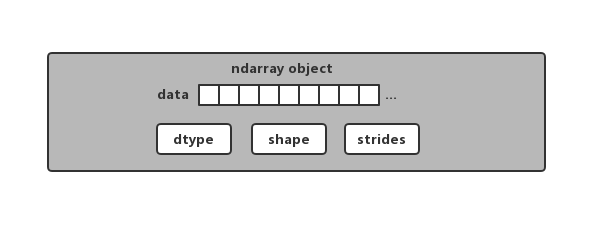

例如，一个10*5的数组，其shape为(10,5)

In [2]:
import numpy as np
np.ones((10,5)).shape

(10, 5)

一个典型的（C阶）3*4*5 float64值（8字节）的数组具有跨度(160,40,8)（理解跨度可能是有用的，因为通常特定轴上的跨度越大，沿着该轴执行计算的代价越高）：

In [3]:
np.ones((3,4,5),dtype=np.float64).strides

(160, 40, 8)

虽然一般的NumPy用户很少会对数组跨度（strides）感兴趣，但它们是构建“零复制”数组视图的关键因素。跨度甚至可以是负的，这使得数组能够穿过内存“向后”移动（例如，在诸如obj[::-1]或object[:,::-1]的切片中就是这种情况。

# NumPy dtype层次结构
你可能时不时会需要写代码检查数组是否包含整数、浮点数、字符串或Python对象。由于浮点数有多种类型(float16到float128)，因此检查dtype是否在类型列表中会非常麻烦。幸运的是，dtype有超类，如np.integer和np.floating，它们可以和np.issubtype函数一起使用：

In [6]:
ints=np.ones(10,dtype=np.uint16)
floats=np.ones(10,dtype=np.float32)

np.issubdtype(ints.dtype,np.integer)

True

In [5]:
np.issubdtype(floats.dtype,np.floating)

True

你可以通过调用类型的mro方法来查看特定dtype的所有父类：

In [7]:
np.float64.mro()

[numpy.float64,
 numpy.floating,
 numpy.inexact,
 numpy.number,
 numpy.generic,
 float,
 object]

因此，我们可以得到：

In [8]:
np.issubdtype(ints.dtype,np.number)

True

大部分NumPy用户不必知道这点，但知道了就偶尔可以派上用场。

# 高阶数组操作
除了神奇索引、切片和布尔值子集外，还有很多方式可以处理数组。虽然不部分数据分析应用程序的繁重工作都是由pandas中的高级函数处理的，但有时候你可能需要编写一些在现有库中找不到的数据算法。

## 重塑数组
在很多情况下，你将数组从一个形状转换为另一个形状，并且不复制任何数据。为了实现这个功能，可以向reshape数组实例方法传递一个表示新形状的元组。例如，假设我们有一个一维数组，我们想要把该数组重新排列进一个矩阵：

In [9]:
arr=np.arange(8)
arr

array([0, 1, 2, 3, 4, 5, 6, 7])

In [10]:
arr.reshape((4,2))

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7]])

多维数组也可以被重塑：

In [11]:
arr.reshape((4,2)).reshape((2,4))

array([[0, 1, 2, 3],
       [4, 5, 6, 7]])

传递的形状维度可以有一个值是-1，表示维度通过数据进行推断：

In [12]:
arr=np.arange(15)
arr.reshape((5,-1))

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14]])

由于数组的shape属性是一个元组，它可以被传递给reshape:

In [13]:
other_arr=np.ones((3,5))
other_arr.shape

(3, 5)

In [14]:
arr.reshape(other_arr.shape)

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]])

reshape的反操作可以将更高维度的数组转换为一维数组，这种操作通常被称为扁平化(flattening)或分散化(raveling):

In [16]:
arr=np.arange(15).reshape((5,3))
arr

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14]])

In [17]:
arr.ravel()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

如果结果中的值在原始数组中是连续的，则ravel不会生成底层数据的副本。flatten方法的行为类似于ravel，但它总是返回数据的副本：

In [18]:
arr.flatten()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

# 连接和分隔数组
numpy.concatenate可以获取数组的序列（元组、列表等），并沿着输入将它们按顺序连接在一起：

In [1]:
import numpy as np
arr1=np.array([[1,2,3],[4,5,6]])
arr2=np.array([[7,8,9],[10,11,12]])

np.concatenate([arr1,arr2],axis=0)

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [2]:
arr1

array([[1, 2, 3],
       [4, 5, 6]])

In [3]:
arr2

array([[ 7,  8,  9],
       [10, 11, 12]])

In [4]:
np.concatenate([arr1,arr2],axis=1)

array([[ 1,  2,  3,  7,  8,  9],
       [ 4,  5,  6, 10, 11, 12]])

对于常见的连接类型有一些方便的函数，比如vstack和hstack。之前的操作可以这样表达：

In [5]:
np.vstack((arr1,arr2))

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [6]:
np.hstack((arr1,arr2))

array([[ 1,  2,  3,  7,  8,  9],
       [ 4,  5,  6, 10, 11, 12]])

另一方面，split可以将一个数组沿轴向切片成多个数组:

In [7]:
arr=np.random.randn(5,2)
arr

array([[-0.2968348 , -0.89644327],
       [-0.06372353,  0.03210917],
       [-0.55242838,  0.01845089],
       [-0.26116344, -1.1679154 ],
       [ 2.55112168, -0.02209042]])

In [21]:
first,second,third=np.split(arr,[1,3])
first

array([[-0.2968348 , -0.89644327]])

In [22]:
second

array([[-0.06372353,  0.03210917],
       [-0.55242838,  0.01845089]])

In [24]:
third

array([[-0.26116344, -1.1679154 ],
       [ 2.55112168, -0.02209042]])

传递给np.split的值[1,3]表示将数组拆分时的索引位置。

# 堆叠助手：r_和c_
在NumPy命名空间中有两个特殊的对象：r_和c_，它们可以使堆栈数组的操作更为简洁：

In [25]:
arr=np.arange(6)
arr1=arr.reshape((3,2))
arr2=np.random.randn(3,2)
np.r_[arr1,arr2]

array([[ 0.        ,  1.        ],
       [ 2.        ,  3.        ],
       [ 4.        ,  5.        ],
       [ 0.7143498 , -1.26746911],
       [ 1.47009257, -0.43805255],
       [ 0.07235289, -0.41720165]])

In [26]:
np.c_[np.r_[arr1,arr2],arr]

array([[ 0.        ,  1.        ,  0.        ],
       [ 2.        ,  3.        ,  1.        ],
       [ 4.        ,  5.        ,  2.        ],
       [ 0.7143498 , -1.26746911,  3.        ],
       [ 1.47009257, -0.43805255,  4.        ],
       [ 0.07235289, -0.41720165,  5.        ]])

这些函数还可以将切片转换为数组：

In [27]:
np.c_[1:6,-10:-5]

array([[  1, -10],
       [  2,  -9],
       [  3,  -8],
       [  4,  -7],
       [  5,  -6]])

# 重复元素：tile和repeat
repeat和tile函数是用于重复或复制数组的两个有用的工具。repeat函数按照给定次数对数组中的每个元素进行复制，生成一个更大的数组：

In [28]:
arr=np.arange(3)
arr

array([0, 1, 2])

In [29]:
arr.repeat(3)

array([0, 0, 0, 1, 1, 1, 2, 2, 2])

默认情况下，如果你传递一个整数，每个元素都会复制相应的次数。如果你传递了一个整数数组，每个元素都会重复相应的不同次数：

In [30]:
arr.repeat([2,3,4])

array([0, 0, 1, 1, 1, 2, 2, 2, 2])

多维数组可以在指定的轴向上对它们的元素进行重复：

In [31]:
arr=np.random.randn(2,2)
arr

array([[ 2.20893511, -1.53863177],
       [-0.58156228,  0.41556527]])

In [32]:
arr.repeat(2,axis=0)

array([[ 2.20893511, -1.53863177],
       [ 2.20893511, -1.53863177],
       [-0.58156228,  0.41556527],
       [-0.58156228,  0.41556527]])

请注意，如果没有传递轴，数组将首先扁平化，这可能不是你想要的。同样，需要按照不同次数重复多维数组的切片时，你可以传递一个整数数组：

In [33]:
arr.repeat([2,3],axis=0)

array([[ 2.20893511, -1.53863177],
       [ 2.20893511, -1.53863177],
       [-0.58156228,  0.41556527],
       [-0.58156228,  0.41556527],
       [-0.58156228,  0.41556527]])

In [34]:
arr.repeat([2,3],axis=1)

array([[ 2.20893511,  2.20893511, -1.53863177, -1.53863177, -1.53863177],
       [-0.58156228, -0.58156228,  0.41556527,  0.41556527,  0.41556527]])

另一方面，tile是一种快捷方法，它可以沿着轴向堆叠副本。在视觉上，你可以把它看作类似于“铺设瓷砖”：

In [35]:
arr

array([[ 2.20893511, -1.53863177],
       [-0.58156228,  0.41556527]])

In [36]:
np.tile(arr,2)

array([[ 2.20893511, -1.53863177,  2.20893511, -1.53863177],
       [-0.58156228,  0.41556527, -0.58156228,  0.41556527]])

第二个参数是瓷砖的数量。用标量来说，铺设是逐行进行的，而不是逐列。tile的第二个参数可以是表示“铺瓷砖”布局的元组：

In [37]:
arr

array([[ 2.20893511, -1.53863177],
       [-0.58156228,  0.41556527]])

In [39]:
np.tile(arr,(2,1))

array([[ 2.20893511, -1.53863177],
       [-0.58156228,  0.41556527],
       [ 2.20893511, -1.53863177],
       [-0.58156228,  0.41556527]])

In [43]:
np.tile(arr,(3,2))

array([[ 2.20893511, -1.53863177,  2.20893511, -1.53863177],
       [-0.58156228,  0.41556527, -0.58156228,  0.41556527],
       [ 2.20893511, -1.53863177,  2.20893511, -1.53863177],
       [-0.58156228,  0.41556527, -0.58156228,  0.41556527],
       [ 2.20893511, -1.53863177,  2.20893511, -1.53863177],
       [-0.58156228,  0.41556527, -0.58156228,  0.41556527]])

# 神奇索引的等价方法：take和put
使用整数数组通过索引是获取、设置数组子集的一种方式：

In [1]:
import numpy as np
arr=np.arange(10)*100
inds=[7,1,2,6]
arr[inds]

array([700, 100, 200, 600])

还有其他一些ndarray方法可以用于特殊情况下在单个轴上的数据选取：

In [2]:
arr.take(inds)

array([700, 100, 200, 600])

In [3]:
arr.put(inds,42)

In [4]:
arr

array([  0,  42,  42, 300, 400, 500,  42,  42, 800, 900])

In [5]:
arr.put(inds,[40,41,42,43])

In [6]:
arr

array([  0,  41,  42, 300, 400, 500,  43,  40, 800, 900])

如果要在别的轴上使用take,你可以传递axis关键字：

In [7]:
inds=[2,0,2,1]
arr=np.random.randn(2,4)
arr

array([[ 0.25802601, -0.26462229, -0.32090069,  1.33481538],
       [-0.12239262, -0.57562821, -1.44648441,  0.04686822]])

In [8]:
arr.take(inds,axis=1)

array([[-0.32090069,  0.25802601, -0.32090069, -0.26462229],
       [-1.44648441, -0.12239262, -1.44648441, -0.57562821]])

# 广播
广播描述了算法如何在不同形状的数组之间进行运算。它是一个强大的功能，但可能会导致混淆，即使对于有经验的用户也是如此。最简单的广播示例发生在将标量值与数组组合的时候：

In [9]:
import numpy as np
arr=np.arange(5)
arr

array([0, 1, 2, 3, 4])

In [10]:
arr*4

array([ 0,  4,  8, 12, 16])

上面将标量值4广播给乘法运算的所有其他运算。
例如，我们可以通过减去列均值来降低数组中的每一列的数值。在这种情况下，它非常简单：

In [11]:
arr=np.random.randn(4,3)
arr.mean(0)

array([-0.48655149,  0.02371485, -0.63315085])

In [12]:
demeaned=arr-arr.mean(0)

In [13]:
demeaned

array([[ 0.35544128,  1.57362507,  0.07211572],
       [-0.79959942, -1.49723611, -1.04914844],
       [ 0.26789356, -0.86045838, -0.07456584],
       [ 0.17626458,  0.78406942,  1.05159857]])

In [14]:
demeaned.mean(0)

array([-1.38777878e-17,  0.00000000e+00,  5.55111512e-17])

In [15]:
arr

array([[-0.13111021,  1.59733992, -0.56103513],
       [-1.28615091, -1.47352126, -1.68229929],
       [-0.21865794, -0.83674353, -0.70771669],
       [-0.31028692,  0.80778427,  0.41844773]])

In [19]:
row_means=arr.mean(1)
row_means

array([ 0.30173153, -1.48065715, -0.58770605,  0.30531503])

In [17]:
row_means.shape

(4,)

In [18]:
row_means.reshape((4,1))

array([[ 0.30173153],
       [-1.48065715],
       [-0.58770605],
       [ 0.30531503]])

In [20]:
row_demeaned=arr-row_means.reshape((4,1))
row_demeaned

array([[-0.43284174,  1.29560839, -0.86276666],
       [ 0.19450624,  0.00713589, -0.20164214],
       [ 0.36904812, -0.24903748, -0.12001064],
       [-0.61560194,  0.50246925,  0.1131327 ]])

In [21]:
row_demeaned.mean(1)

array([-3.70074342e-17,  1.48029737e-16, -7.40148683e-17,  1.85037171e-17])

# 通过广播设定数组的值
控制算法运算的相同广播规则也适用于通过数组索引设置值。在一个简单的例子中，我们可以做这样的事情：

In [24]:
import numpy as np
arr=np.zeros((4,3))
arr

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [26]:
arr[:]=5
arr

array([[5., 5., 5.],
       [5., 5., 5.],
       [5., 5., 5.],
       [5., 5., 5.]])

但是，如果我们想要将数值的一维数组设置到数组的列中，只要形状是兼容的就可以做到这一点：

In [27]:
col=np.array([1.28,-0.42,0.44,1.6])
arr[:]=col[:,np.newaxis]
arr

array([[ 1.28,  1.28,  1.28],
       [-0.42, -0.42, -0.42],
       [ 0.44,  0.44,  0.44],
       [ 1.6 ,  1.6 ,  1.6 ]])

In [28]:
arr[:2]=[[-1.37],[0.509]]
arr

array([[-1.37 , -1.37 , -1.37 ],
       [ 0.509,  0.509,  0.509],
       [ 0.44 ,  0.44 ,  0.44 ],
       [ 1.6  ,  1.6  ,  1.6  ]])

# 高阶ufunc用法
Numpy的每个二元ufunc（通用函数）都有特殊的方法来执行某些特殊的向量化操作。
reduce方法接收单个数组并通过执行一系列二元操作在可选的轴向上对数组的值进行聚合。例如，使用np.add.reduce是对数组进行加和的另一种方法：

In [1]:
import numpy as np
arr=np.arange(10)
np.add.reduce(arr)

45

In [30]:
arr.sum()

45

起始值（对于add方法是0）取决于ufunc。如果传递了一个轴，则沿该轴执行缩聚。这使你能够以简洁的方式回答某些种类的问题。作为一个不太重要的例子，我们可以使用np.logical_and检查数组的每一行中的值是否被排序：

In [21]:
np.random.seed(12346) #为了可以复现
arr=np.random.randn(5,5)
arr

array([[-8.99822478e-02,  7.59372617e-01,  7.48336101e-01,
        -9.81497953e-01,  3.65775545e-01],
       [-3.15442628e-01, -8.66135605e-01,  2.78568155e-02,
        -4.55597723e-01, -1.60189223e+00],
       [ 2.48256116e-01, -3.21536673e-01, -8.48730755e-01,
         4.60468309e-04, -5.46459347e-01],
       [ 2.53915229e-01,  1.93684246e+00, -7.99504902e-01,
        -5.69159281e-01,  4.89244731e-02],
       [-6.49092950e-01, -4.79535727e-01, -9.53521432e-01,
         1.42253882e+00,  1.75403128e-01]])

In [29]:
arr[::2] # 选取第0、2、4行

array([[-9.81497953e-01, -8.99822478e-02,  3.65775545e-01,
         7.48336101e-01,  7.59372617e-01],
       [-8.48730755e-01, -5.46459347e-01, -3.21536673e-01,
         4.60468309e-04,  2.48256116e-01],
       [-9.53521432e-01, -6.49092950e-01, -4.79535727e-01,
         1.75403128e-01,  1.42253882e+00]])

In [28]:
arr[::2].sort(1) #选取第0、2、4行进行排序

In [26]:
arr

array([[-9.81497953e-01, -8.99822478e-02,  3.65775545e-01,
         7.48336101e-01,  7.59372617e-01],
       [-3.15442628e-01, -8.66135605e-01,  2.78568155e-02,
        -4.55597723e-01, -1.60189223e+00],
       [-8.48730755e-01, -5.46459347e-01, -3.21536673e-01,
         4.60468309e-04,  2.48256116e-01],
       [ 2.53915229e-01,  1.93684246e+00, -7.99504902e-01,
        -5.69159281e-01,  4.89244731e-02],
       [-9.53521432e-01, -6.49092950e-01, -4.79535727e-01,
         1.75403128e-01,  1.42253882e+00]])

In [30]:
arr[:,:-1]<arr[:,1:]

array([[ True,  True,  True,  True],
       [False,  True, False, False],
       [ True,  True,  True,  True],
       [ True, False,  True,  True],
       [ True,  True,  True,  True]])

In [31]:
np.logical_and.reduce(arr[:,:-1] < arr[:,1:],axis=1)

array([ True, False,  True, False,  True])

请注意，logical_and.reduce等价于all方法。

accumlate与reduce是相关的，就像cumsum与sum相关一样。accumulate生成一个数组，其尺寸与中间“累计”值相同：

In [32]:
arr=np.arange(15).reshape((3,5))
np.add.accumulate(arr,axis=1)

array([[ 0,  1,  3,  6, 10],
       [ 5, 11, 18, 26, 35],
       [10, 21, 33, 46, 60]], dtype=int32)

outer在两个数组之间执行成对的交叉乘积：

In [35]:
arr=np.arange(3).repeat([1,2,2])
arr

array([0, 1, 1, 2, 2])

In [36]:
np.multiply.outer(arr,np.arange(5))

array([[0, 0, 0, 0, 0],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 2, 4, 6, 8],
       [0, 2, 4, 6, 8]])

outer的输出的维度等于输入的维度总和：

In [37]:
x,y=np.random.randn(3,4),np.random.randn(5)
result=np.subtract.outer(x,y)
result.shape

(3, 4, 5)

In [38]:
result

array([[[-0.07129513,  1.80587986,  0.04445711, -0.77002945,
          0.37076839],
        [-0.48729668,  1.38987831, -0.37154444, -1.18603099,
         -0.04523316],
        [-0.49099936,  1.38617563, -0.37524711, -1.18973367,
         -0.04893584],
        [-0.70194533,  1.17522966, -0.58619309, -1.40067964,
         -0.25988181]],

       [[-0.5388528 ,  1.33832219, -0.42310056, -1.23758711,
         -0.09678928],
        [-0.39734742,  1.47982757, -0.28159518, -1.09608173,
          0.0447161 ],
        [-0.78758534,  1.08958965, -0.6718331 , -1.48631965,
         -0.34552182],
        [-2.05029021, -0.17311522, -1.93453796, -2.74902452,
         -1.60822669]],

       [[ 0.2637349 ,  2.14090989,  0.37948715, -0.43499941,
          0.70579842],
        [-1.3352883 ,  0.54188669, -1.21953606, -2.03402261,
         -0.89322478],
        [-1.37407525,  0.50309974, -1.25832301, -2.07280956,
         -0.93201173],
        [-0.70013722,  1.17703777, -0.58438498, -1.39887153,
         -0

最后一个方法reduceat执行“本地缩聚”，本质上是一个数组groupby操作，在操作中数组的切片聚合在一起。reduceat方法接受一系列的“箱体边缘”，这些箱体边缘表示如何分割以及聚合数据值：

In [39]:
arr=np.arange(10)
np.add.reduceat(arr,[0,5,8])

array([10, 18, 17], dtype=int32)

结果是在arr[0:5],arr[5:8]和arr[8:]上执行了缩聚（此处是加和）。在其他方法中，你可以传递一个axis参数：

In [40]:
arr=np.multiply.outer(np.arange(4),np.arange(5))
arr

array([[ 0,  0,  0,  0,  0],
       [ 0,  1,  2,  3,  4],
       [ 0,  2,  4,  6,  8],
       [ 0,  3,  6,  9, 12]])

In [41]:
np.add.reduceat(arr,[0,2,4],axis=1)

array([[ 0,  0,  0],
       [ 1,  5,  4],
       [ 2, 10,  8],
       [ 3, 15, 12]], dtype=int32)